# Image classifier for the SVHN dataset

In [68]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

![SVHN overview image](data/svhn_examples.jpg)
We will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## Inspect and preprocess the dataset

In [3]:
# Define variables to store the train data and labels
x_train = np.moveaxis(train['X'], -1, 0)
y_train = train['y']

# Define variables to store the test data and labels
x_test = np.moveaxis(test['X'], -1, 0)
y_test = test['y']

In [4]:
x_train.shape

(73257, 32, 32, 3)

In [5]:
y_train.shape

(73257, 1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


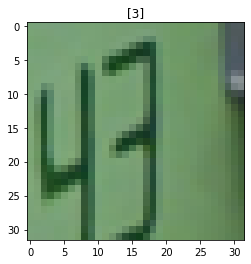

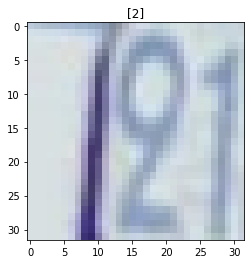

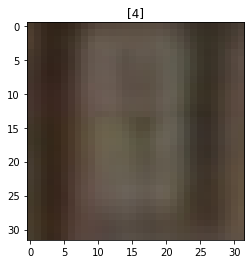

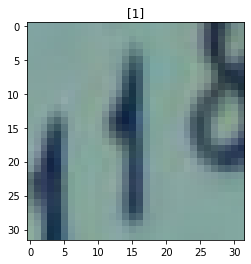

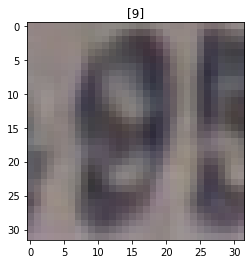

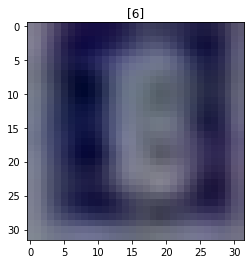

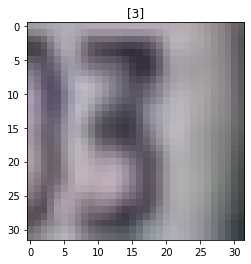

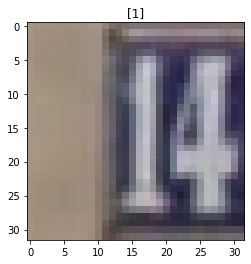

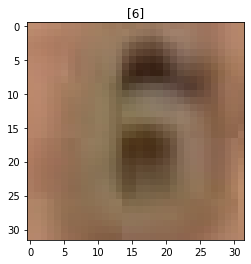

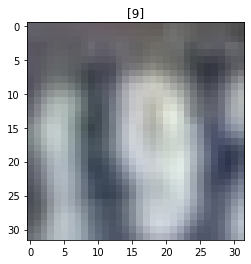

In [6]:
# Select random images
n_imgs = 10
inds = np.random.choice(y_train.shape[0], size=n_imgs, replace=False)

for i in inds:
    img = x_train[i]
    lbl = y_train[i]
    plt.imshow(img)
    plt.title(lbl)
    plt.show()

In [7]:
# Convert the img into greyscale
def convert_greyscale(data):
    
    return np.mean(data, axis=3).reshape(-1, 32, 32, 1)/255.

In [8]:
# Convert the training dataset into greyscale
x_train_greyscale = convert_greyscale(x_train)

# Convert the test dataset into greyscale
x_test_greyscale = convert_greyscale(x_test)

In [9]:
x_train_greyscale.shape

(73257, 32, 32, 1)

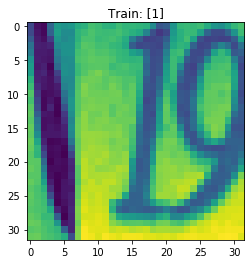

In [10]:
# Plot a greyscale image from the training dataset
ind = 0
plt.imshow(x_train_greyscale[ind, :, :, 0])
plt.title("Train: " + str(y_train[ind]))
plt.show()

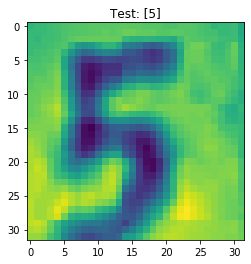

In [11]:
# Plot a greyscale image from the test dataset
ind = 0
plt.imshow(x_test_greyscale[ind, :, :, 0])
plt.title("Test: " + str(y_test[ind]))
plt.show()

In [12]:
# Transform the train and test labels
enc = OneHotEncoder(sparse=False)  # Define the one hot encoder

# Transform the train labels
y_train_cat = enc.fit_transform(y_train)

# Transform the test labels
y_test_cat = enc.fit_transform(y_test)

## Feedforward neural network

In [13]:
# Define feedforward model
def get_mlp_model(input_shape):
    
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])
    
    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

In [14]:
input_shape = x_train_greyscale[0].shape  # Define the input shape of the model
mlp_model = get_mlp_model(input_shape)  # get the mlp model

In [15]:
mlp_model.summary()  # Print the model summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
__________________________________________________

In [16]:
# Define a callback to reduce the learning rate when training plateau's
lr_plateau = ReduceLROnPlateau(monitor="val_accuracy", verbose=1, patience=5)

# Define an earlystopping callback
earlystopping = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1)

# Define a model checkpoint callback
ckpt_path = "my_models/"
ckpt = ModelCheckpoint(ckpt_path, save_best_only=True,
                      monitor="val_accuracy", verbose=1)

callbacks = [lr_plateau, ckpt, earlystopping]

In [17]:
# Fit the model
epochs = 30
batch_size = 128
mlp_history = mlp_model.fit(x_train_greyscale, y_train_cat, epochs=epochs,
                            batch_size=batch_size, validation_split=0.2, 
                            callbacks=callbacks, use_multiprocessing=True)

Epoch 1/30
458/458 [==============================] - 3s 5ms/step - loss: 2.2308 - accuracy: 0.1913 - val_loss: 1.6935 - val_accuracy: 0.4063

Epoch 00001: val_accuracy improved from -inf to 0.40629, saving model to my_models/
INFO:tensorflow:Assets written to: my_models/assets
Epoch 2/30
458/458 [==============================] - 2s 4ms/step - loss: 1.6018 - accuracy: 0.4441 - val_loss: 1.4168 - val_accuracy: 0.5332

Epoch 00002: val_accuracy improved from 0.40629 to 0.53324, saving model to my_models/
INFO:tensorflow:Assets written to: my_models/assets
Epoch 3/30
458/458 [==============================] - 2s 4ms/step - loss: 1.2932 - accuracy: 0.5752 - val_loss: 1.1113 - val_accuracy: 0.6486

Epoch 00003: val_accuracy improved from 0.53324 to 0.64865, saving model to my_models/
INFO:tensorflow:Assets written to: my_models/assets
Epoch 4/30
458/458 [==============================] - 2s 5ms/step - loss: 1.0896 - accuracy: 0.6552 - val_loss: 1.0478 - val_accuracy: 0.6674

Epoch 00004: v

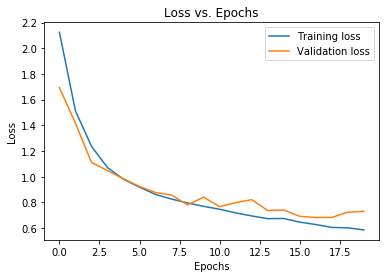

In [18]:
# Plot loss vs. epoch for the training and validation sets
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

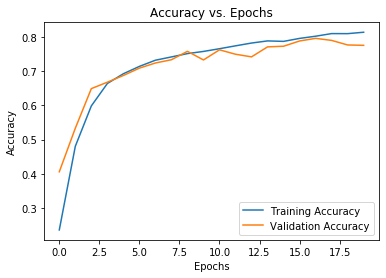

In [19]:
# Plot accuracy vs. epoch for the training and validation sets
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [24]:
# Evaluate the model
mlp_eval = mlp_model.evaluate(x_test_greyscale, y_test_cat, return_dict=True)
print("\nTest loss: {}".format(mlp_eval['loss']))
print("Test accuracy: {}".format(mlp_eval['accuracy']))

814/814 [==============================] - 1s 772us/step - loss: 0.8159 - accuracy: 0.7565

Test loss: 0.8158629536628723
Test accuracy: 0.756492018699646


## CNN neural network

In [60]:
# Define the CNN model
def get_cnn_model(input_shape, dropout_rate):
    
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(32, 32, 1), padding="same", activation="relu"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Conv2D(16, (3, 3), padding="same", activation="relu"),
        Dropout(dropout_rate),
        Conv2D(8, (3, 3), padding="same", activation="relu"),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])
    
    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

In [61]:
# Get the CNN model
input_shape = x_train_greyscale[0].shape
dropout_rate = 0.3
cnn_model = get_cnn_model(input_shape, dropout_rate)

# Print the model summary
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 8)        

In [62]:
# Define a model checkpoint callback for the CNN model
cnn_ckpt_path = "my_cnn_models/"
cnn_ckpt = ModelCheckpoint(cnn_ckpt_path, save_best_only=True, 
                           monitor="val_accuracy", verbose=1)

cnn_callbacks = [lr_plateau, cnn_ckpt, earlystopping]

In [63]:
# Fit the model
epochs = 30
batch_size = 64
cnn_history = cnn_model.fit(x_train_greyscale, y_train_cat, epochs=epochs,
                            batch_size=batch_size, validation_split=0.2, 
                            callbacks=cnn_callbacks, use_multiprocessing=True)

Epoch 1/30
916/916 [==============================] - 76s 82ms/step - loss: 1.5475 - accuracy: 0.4775 - val_loss: 0.5223 - val_accuracy: 0.8449

Epoch 00001: val_accuracy improved from -inf to 0.84487, saving model to my_cnn_models/
INFO:tensorflow:Assets written to: my_cnn_models/assets
Epoch 2/30
916/916 [==============================] - 75s 82ms/step - loss: 0.5034 - accuracy: 0.8461 - val_loss: 0.5190 - val_accuracy: 0.8358

Epoch 00002: val_accuracy did not improve from 0.84487
Epoch 3/30
916/916 [==============================] - 72s 79ms/step - loss: 0.4149 - accuracy: 0.8706 - val_loss: 0.4384 - val_accuracy: 0.8681

Epoch 00003: val_accuracy improved from 0.84487 to 0.86807, saving model to my_cnn_models/
INFO:tensorflow:Assets written to: my_cnn_models/assets
Epoch 4/30
916/916 [==============================] - 74s 81ms/step - loss: 0.3733 - accuracy: 0.8834 - val_loss: 0.3884 - val_accuracy: 0.8807

Epoch 00004: val_accuracy improved from 0.86807 to 0.88070, saving model t

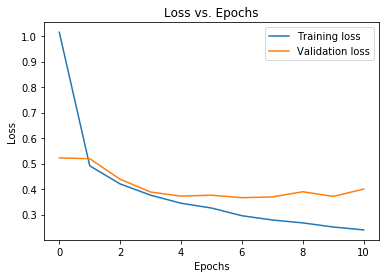

In [64]:
# Plot loss vs. epoch for the training and validation sets
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

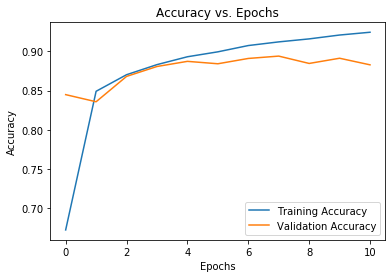

In [65]:
# Plot accuracy vs. epoch for the training and validation sets
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [66]:
# Evaluate the model
cnn_eval = cnn_model.evaluate(x_test_greyscale, y_test_cat, return_dict=True)
print("\nTest loss: {}".format(cnn_eval['loss']))
print("Test accuracy: {}".format(cnn_eval['accuracy']))

814/814 [==============================] - 9s 11ms/step - loss: 0.4443 - accuracy: 0.8704

Test loss: 0.4442964494228363
Test accuracy: 0.8703902959823608


## Get model predictions

In [69]:
# Load the MLP model
load_mlp_model = load_model(ckpt_path)

# Load the CNN model
load_cnn_model = load_model(cnn_ckpt_path)

In [78]:
# Select random images from the test set
n_imgs = 5
inds = np.random.choice(y_test.shape[0], size=n_imgs, replace=False)

rnd_x_test = x_test_greyscale[inds]
rnd_y_test = y_test[inds]

In [79]:
# Get predictions from the MLP model
mlp_pred = load_mlp_model.predict(rnd_x_test)

# Get predictions from the CNN model
cnn_pred = load_cnn_model.predict(rnd_x_test)

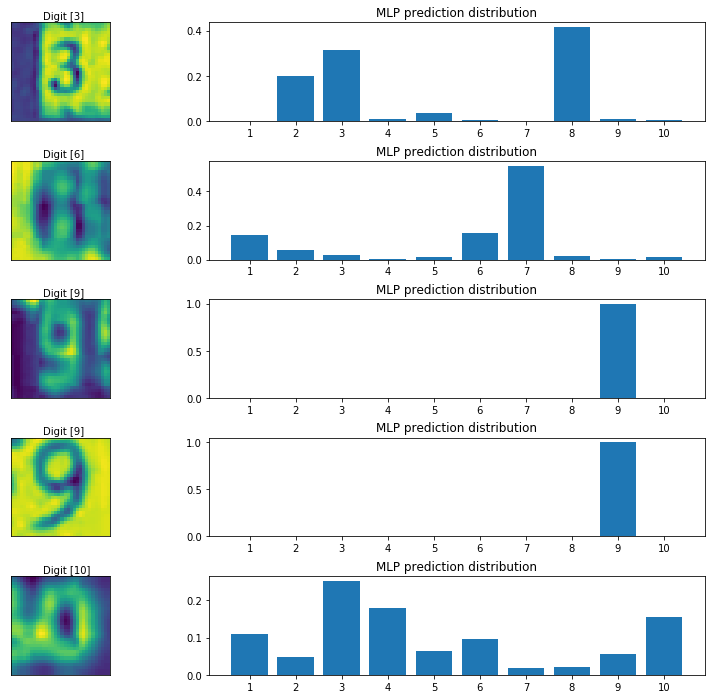

In [81]:
# Predictions from the MLP model
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(mlp_pred, rnd_x_test, rnd_y_test)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("MLP prediction distribution")
    
plt.show()

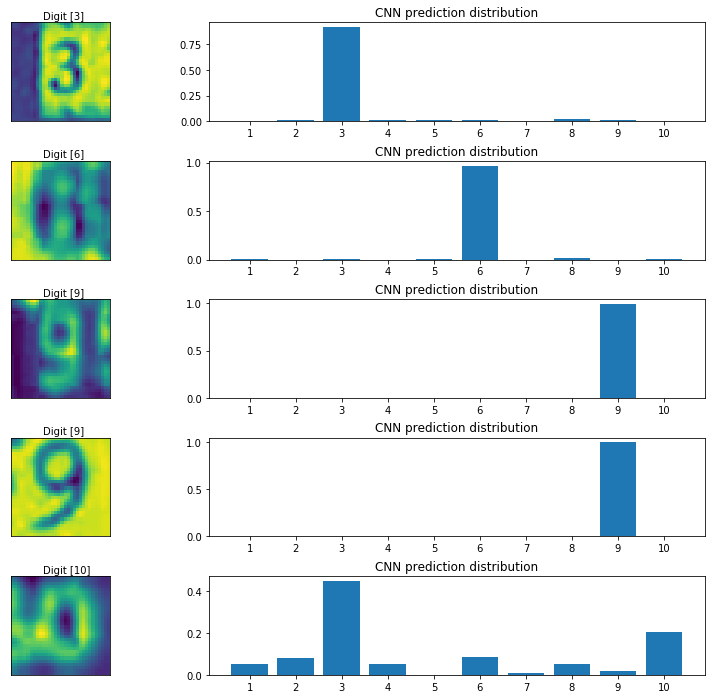

In [82]:
# Predictions from the CNN model
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(cnn_pred, rnd_x_test, rnd_y_test)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("CNN prediction distribution")
    
plt.show()